In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
storage_options = {
    "client_kwargs": { "endpoint_url": "http://localhost:4566"}, "key": "test", "secret": "test"
}
df = pd.read_parquet("s3://ev-data/processed/", storage_options=storage_options,engine="pyarrow")
df.head()

,session_id,garage_id,user_id,user_type,shared_id,start_plugin,start_plugin_hour,end_plugout,end_plugout_hour,el_kwh,duration_hours,month_plugin,weekdays_plugin,plugin_category,duration_category,hour
0,1,AdO3,AdO3-4,Private,NaN,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours,2018-12-21 10:00:00
1,2,AdO3,AdO3-4,Private,NaN,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours,2018-12-21 10:00:00
2,3,AdO3,AdO3-4,Private,NaN,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours,2018-12-21 11:00:00
3,4,AdO3,AdO3-2,Private,NaN,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours,2018-12-22 16:00:00
4,5,AdO3,AdO3-2,Private,NaN,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours,2018-12-24 22:00:00


In [3]:
testing = df[df['duration_hours'] > 24]
testing.sample(5)

,session_id,garage_id,user_id,user_type,shared_id,start_plugin,start_plugin_hour,end_plugout,end_plugout_hour,el_kwh,duration_hours,month_plugin,weekdays_plugin,plugin_category,duration_category,hour
852,853,Bl2,Bl2-3,Private,NaN,2019-04-30 05:02:00,5,2019-05-04 14:47:00,14,2.04,105.741389,Apr,Tuesday,late night (3-6),More than 18 hours,2019-04-30 05:00:00
1026,1027,AdO3,AdO3-2,Private,NaN,2019-05-18 16:46:00,16,2019-05-20 07:21:00,7,9.88,38.580556,May,Saturday,late afternoon (15-18),More than 18 hours,2019-05-18 16:00:00
5345,5346,MS22,AsO4-2,Private,NaN,2019-12-23 12:21:00,12,2019-12-24 12:51:00,12,5.40,24.511389,Dec,Monday,early afternoon (12-15),More than 18 hours,2019-12-23 12:00:00
6560,6561,MS22,AsO4-2,Private,NaN,2020-01-24 13:25:00,13,2020-01-26 16:30:00,16,5.59,51.081111,Jan,Friday,early afternoon (12-15),More than 18 hours,2020-01-24 13:00:00
4698,4699,UT15,UT15-2,Private,NaN,2019-12-06 17:50:00,17,2019-12-09 07:40:00,7,10.21,61.832222,Dec,Friday,late afternoon (15-18),More than 18 hours,2019-12-06 17:00:00


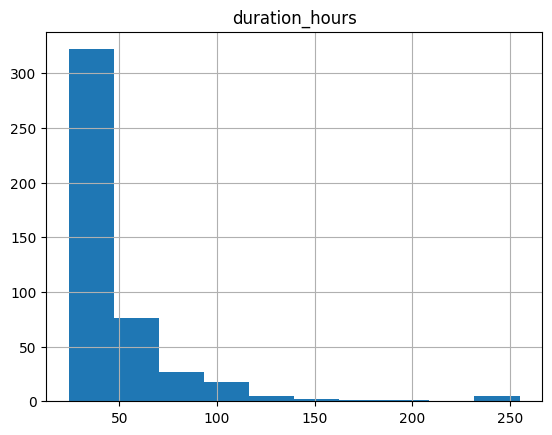

In [4]:
testing.hist(column='duration_hours')
plt.show()

In [5]:
hourly_total = (df.groupby('hour', as_index=True).agg(total_kwh=('el_kwh','sum'),n_sessions=('session_id','count'),avg_kwh=('el_kwh','mean')).sort_index())
print(hourly_total)

                     total_kwh  n_sessions    avg_kwh
hour                                                 
2018-12-21 10:00:00       1.17           2   0.585000
2018-12-21 11:00:00      29.87           1  29.870000
2018-12-22 16:00:00      15.56           1  15.560000
2018-12-24 22:00:00       3.62           1   3.620000
2018-12-24 23:00:00      16.14           1  16.140000
...                        ...         ...        ...
2020-01-31 16:00:00      12.96           3   4.320000
2020-01-31 17:00:00      24.91           3   8.303333
2020-01-31 18:00:00       9.10           1   9.100000
2020-01-31 19:00:00       6.59           2   3.295000
2020-01-31 20:00:00      20.14           1  20.140000

[3340 rows x 3 columns]


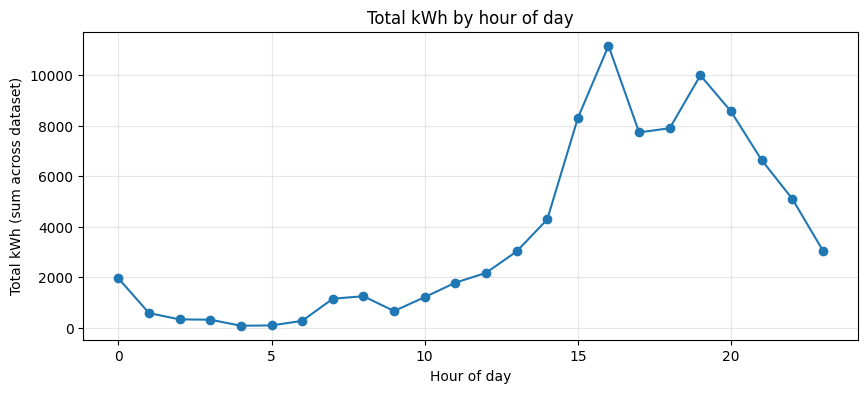

In [6]:
hourly_by_daypart = df.groupby('start_plugin_hour').el_kwh.sum().reindex(range(24))
hourly_mean_by_daypart = df.groupby('start_plugin_hour').el_kwh.mean().reindex(range(24))

plt.figure(figsize=(10,4))
plt.plot(hourly_by_daypart.index, hourly_by_daypart.values, marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Total kWh (sum across dataset)')
plt.title('Total kWh by hour of day')
plt.grid(alpha=0.3)
plt.show()

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_16028\4186395406.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_weekday_hour = df.groupby(['weekdays_plugin','start_plugin_hour']).el_kwh.sum().unstack(0).reindex(columns=weekday_order)


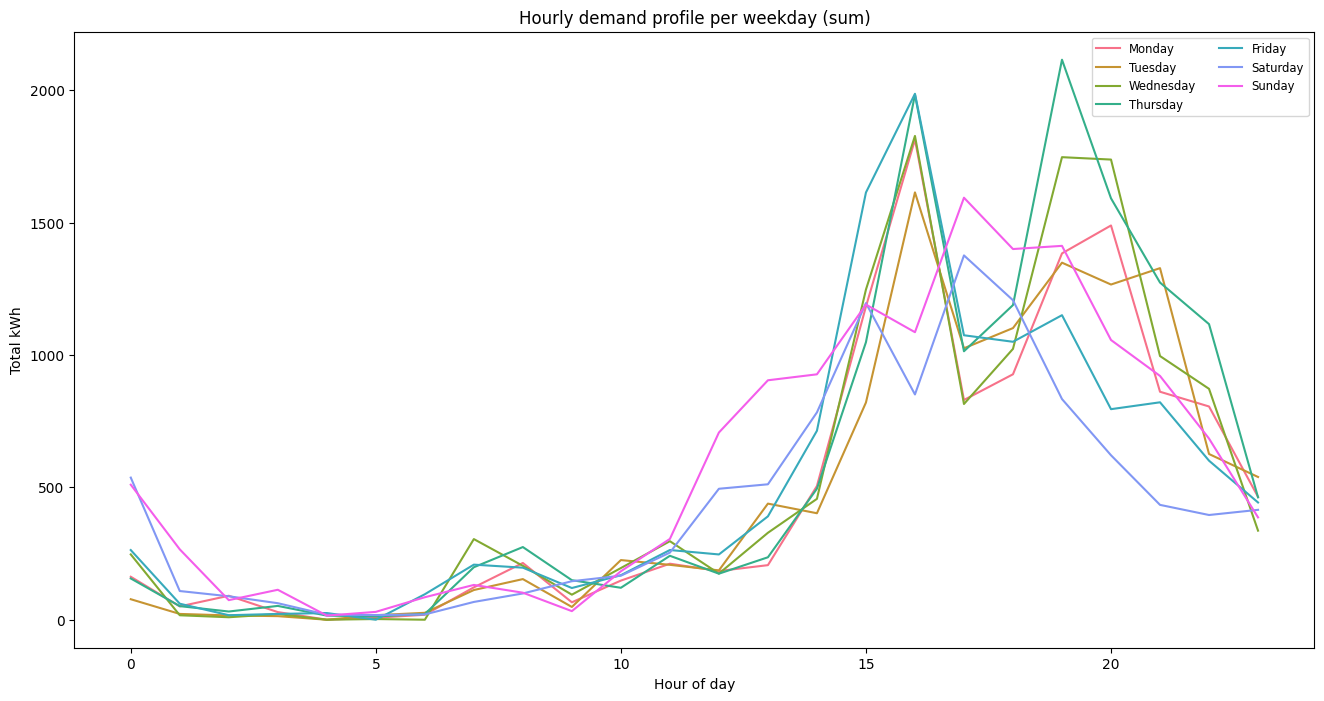

In [16]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
mean_by_weekday_hour = df.groupby(['weekdays_plugin','start_plugin_hour']).el_kwh.sum().unstack(0).reindex(columns=weekday_order)
plt.figure(figsize=(16,8))
colors = sns.color_palette("husl", len(weekday_order))
for color, wd in enumerate(weekday_order):
    plt.plot(mean_by_weekday_hour.index, mean_by_weekday_hour[wd], label=wd, color=colors[color])
plt.legend(ncol=2, fontsize='small')
plt.xlabel('Hour of day')
plt.ylabel('Total kWh')
plt.title('Hourly demand profile per weekday (sum)')
plt.show()

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_16028\3085734983.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_month = df.groupby(['month_plugin','start_plugin_hour']).el_kwh.sum().unstack(0).reindex(columns=month)


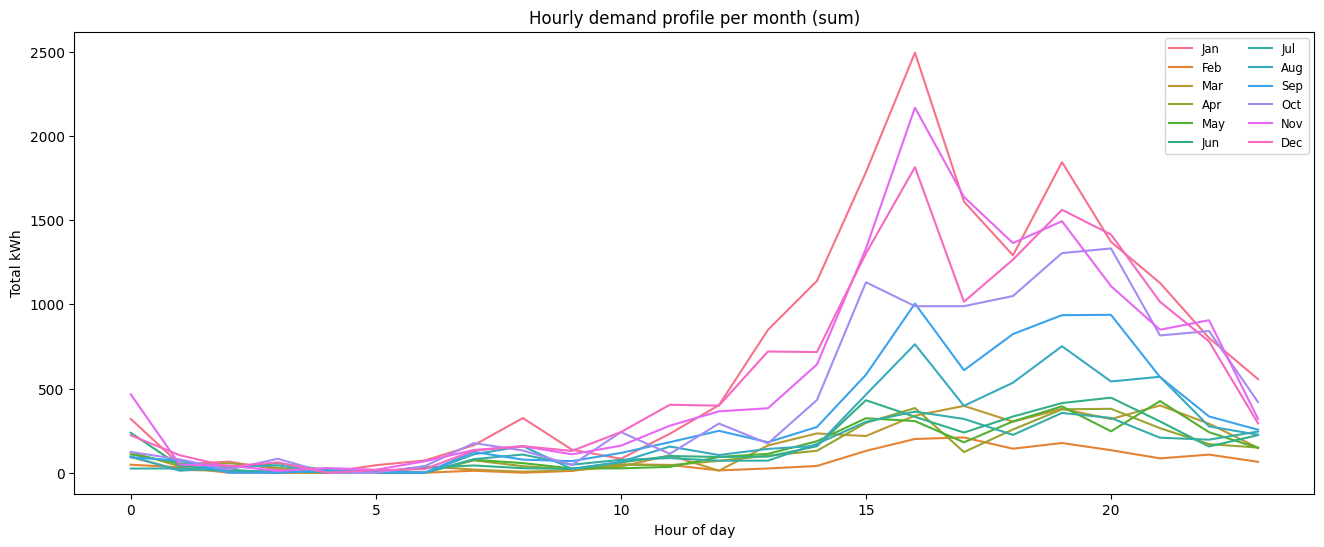

In [17]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mean_by_month = df.groupby(['month_plugin','start_plugin_hour']).el_kwh.sum().unstack(0).reindex(columns=month)
plt.figure(figsize=(16,6))
colors = sns.color_palette("husl", len(month))
for color,m in enumerate(month):
    plt.plot(mean_by_month.index, mean_by_month[m], label=m, color=colors[color])
plt.legend(ncol=2, fontsize='small')
plt.xlabel('Hour of day')
plt.ylabel('Total kWh')
plt.title('Hourly demand profile per month (sum)')
plt.show()

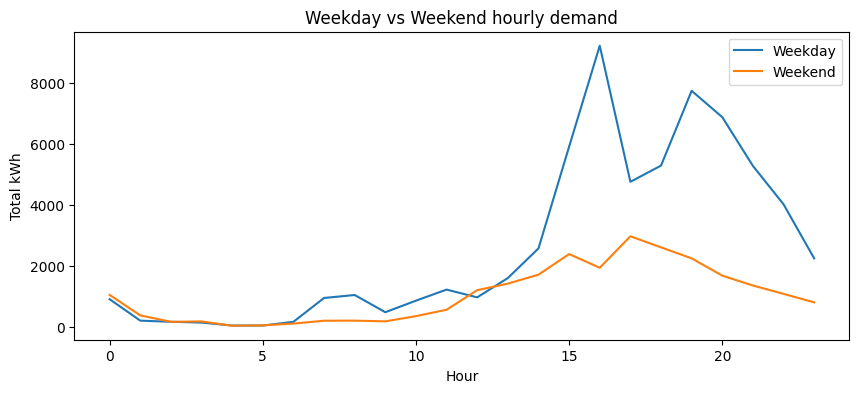

In [9]:
# mark weekend
df['is_weekend'] = df['weekdays_plugin'].isin(['Saturday','Sunday'])
agg_weekend = df.groupby(['is_weekend','start_plugin_hour']).el_kwh.sum().unstack(0)

plt.figure(figsize=(10,4))
plt.plot(agg_weekend.index, agg_weekend[False], label='Weekday')
plt.plot(agg_weekend.index, agg_weekend[True], label='Weekend')
plt.xlabel('Hour')
plt.ylabel('Total kWh')
plt.title('Weekday vs Weekend hourly demand')
plt.legend()
plt.show()


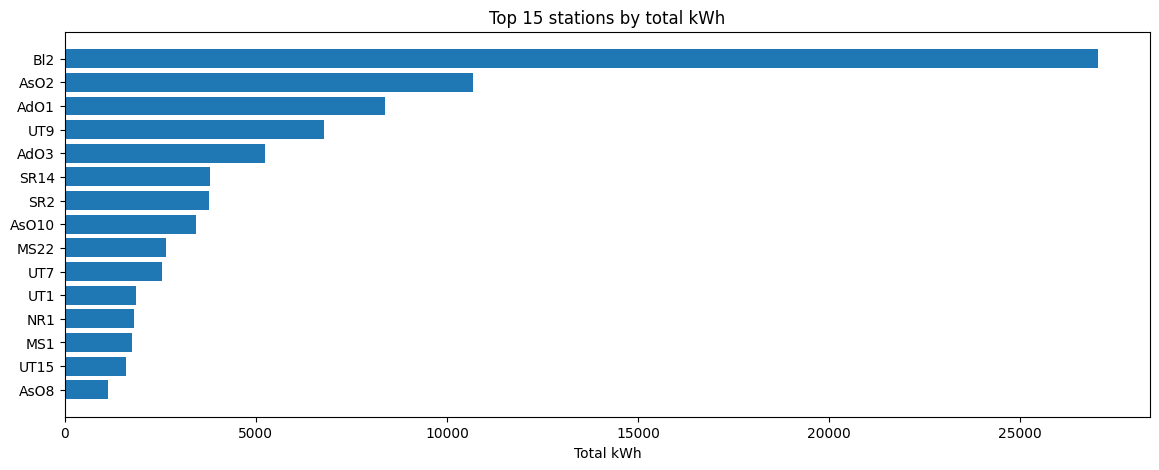

In [10]:
agg_stations = df.groupby('garage_id').agg(total_kwh=('el_kwh','sum'),
                                           n_sessions=('session_id','count'),
                                           avg_kwh=('el_kwh','mean')).sort_values(by='total_kwh', ascending=False)
top = agg_stations.head(15)

plt.figure(figsize=(14,5))
plt.barh(top.index[::-1], top['total_kwh'][::-1])
plt.xlabel('Total kWh')
plt.title('Top 15 stations by total kWh')
plt.show()

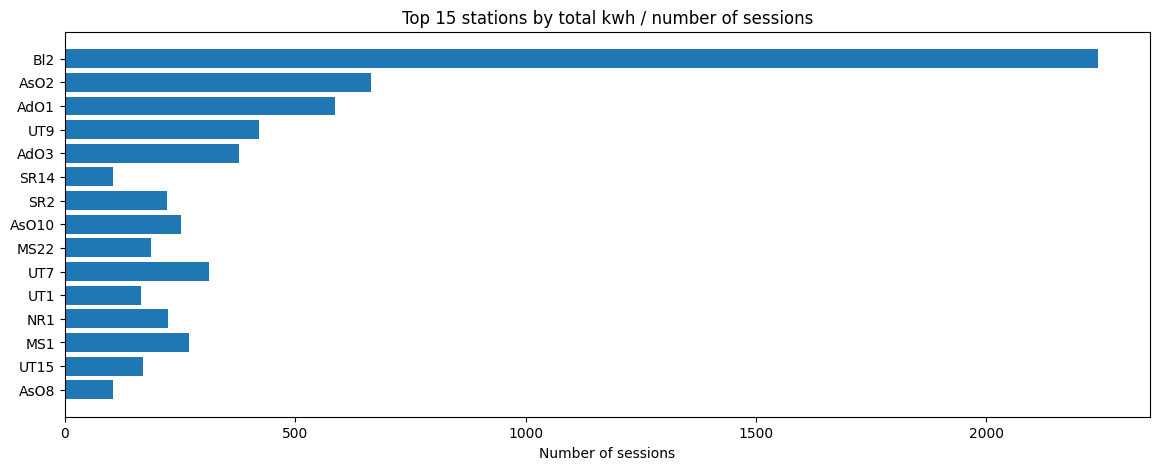

In [11]:

plt.figure(figsize=(14,5))
plt.barh(top.index[::-1], top['n_sessions'][::-1])
plt.xlabel('Number of sessions')
plt.title('Top 15 stations by total kwh / number of sessions')
plt.show()

In [12]:
# outlier detection using IQR
q1 = agg_stations['total_kwh'].quantile(0.25)
q3 = agg_stations['total_kwh'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5*iqr
outliers = agg_stations[agg_stations['total_kwh'] > upper_bound]
print(f'Outlier stations based on total kWh: \n {outliers}')

Outlier stations based on total kWh: 
            total_kwh  n_sessions    avg_kwh
garage_id                                  
Bl2         27046.92        2243  12.058368
AsO2        10672.16         665  16.048361
AdO1         8372.83         586  14.288106
